# Landslide Prediction Using Deep Learning-UNET


by: Sarah Fadhlaldeen and Emerald Olango

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# import torchvision 
import rasterio

from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset, random_split
 
from torchvision.utils import make_grid
from torchvision import transforms
from torchsummary import summary

from model import *
from utils import *

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 Xavier


In [3]:
import wandb  #usign wandb to record the tuning process 

In [4]:
! wandb login 04b0afba9600de0995ad1dd7b83e7588aa00265f

wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc


In [5]:
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'ML-working-trials.ipynb'

In [6]:
### added in wandb all the hyperparameters that were used for tuning ###
wandb.init(project='ML-working-trials.ipynb', entity='sarahfdl', config={
    "patch_size": (24,24),
    "batch_size": 32,
    "hidden_channels": 44,
    "lr": 0.001,
    "weight_decay": 0.001
})



wandb: Currently logged in as: sarahfdl. Use `wandb login --relogin` to force relogin


## 1.Data Preprocessing 

-The data was in the form of vectors and raster files, vectors were rasterized, then all of them were cropped to the area of study size(Papua New Guinea, 107.8 km x 62.9 km).

-The tif images were resized and processed into torch tensors. 7 features were used, they were stacked into multi channel image as the input and target mask was used. Next, the input image mean was centered around 0 and the entire range between 0 and 1.The target mask was binarized again because it showed values between zero and one(not strictly 0 and 1!). Vertical and horizontal augmentation were performed. Finally, real, vertically augmented and horizontally augmented target images with their corresponding targets were divided into patches with controllable size.

-Four datasets were created for real, vertically augmented and horizontally augmented data, and the fourth included them all. The data was divided into 90% training and 10% validation.







In [7]:
###a function to read the images### 
def read_image(img):
    with rasterio.open(img) as src:
        image = src.read()   #(num_bands, height, width)
    return image

###a function to plot the images### 
def plot_images(images, titles, nrows=2, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6))
    for ax, image, title in zip(axes.flat, images, titles):
        if image.shape[0] == 1:  # Single channel
            ax.imshow(image.squeeze(0), cmap='gray')    
        
        else:  # Multichannel image
            ax.imshow(image.transpose(1, 2, 0))  
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

###a function to resize and convert the images into torch tensors###     
def preprocess_image(image, size=(200, 200)):
    image = image.astype(np.float32)
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)
    resize_transform = transforms.Resize(size)
    resized_image = resize_transform(image_tensor.unsqueeze(0)).squeeze(0)
    #print(resized_image.shape)
    return resized_image

###a function to resize, convert the images into torch tensors, perform horizontal augmentation### 
def preprocess_image_augment(image, size=(200, 200)):
    image = image.astype(np.float32)
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)
    resize_transform = transforms.Resize(size)
    flip_transform=transforms.RandomHorizontalFlip(p=1)
    resized_image = resize_transform(image_tensor.unsqueeze(0)).squeeze(0)
    flipped_img =flip_transform(resized_image)
    #print(resized_image.shape)
    return flipped_img

###a function to resize, convert the images into torch tensors, perform vertical augmentation###
def preprocess_image_augmentv(image, size=(200, 200)):
    image = image.astype(np.float32)
    image_tensor = torch.tensor(image, dtype=torch.float32).to(device)
    resize_transform = transforms.Resize(size)
    flip_transform=transforms.RandomVerticalFlip(p=1)
    resized_image = resize_transform(image_tensor.unsqueeze(0)).squeeze(0)
    flipped_img =flip_transform(resized_image)
    #print(resized_image.shape)
    return flipped_img


In [8]:
data_imgs = ["elevation.tif", "geo.tif", "pgv.tif", "rainfall.tif", "relief.tif",
                "slope_avg.tif", "dist_geo.tif", "target.tif"]

feature_imgs = ["elevation.tif", "geo.tif", "pgv.tif", "rainfall.tif", "relief.tif",
                "slope_avg.tif", "dist_geo.tif"]

target_img = "target.tif"

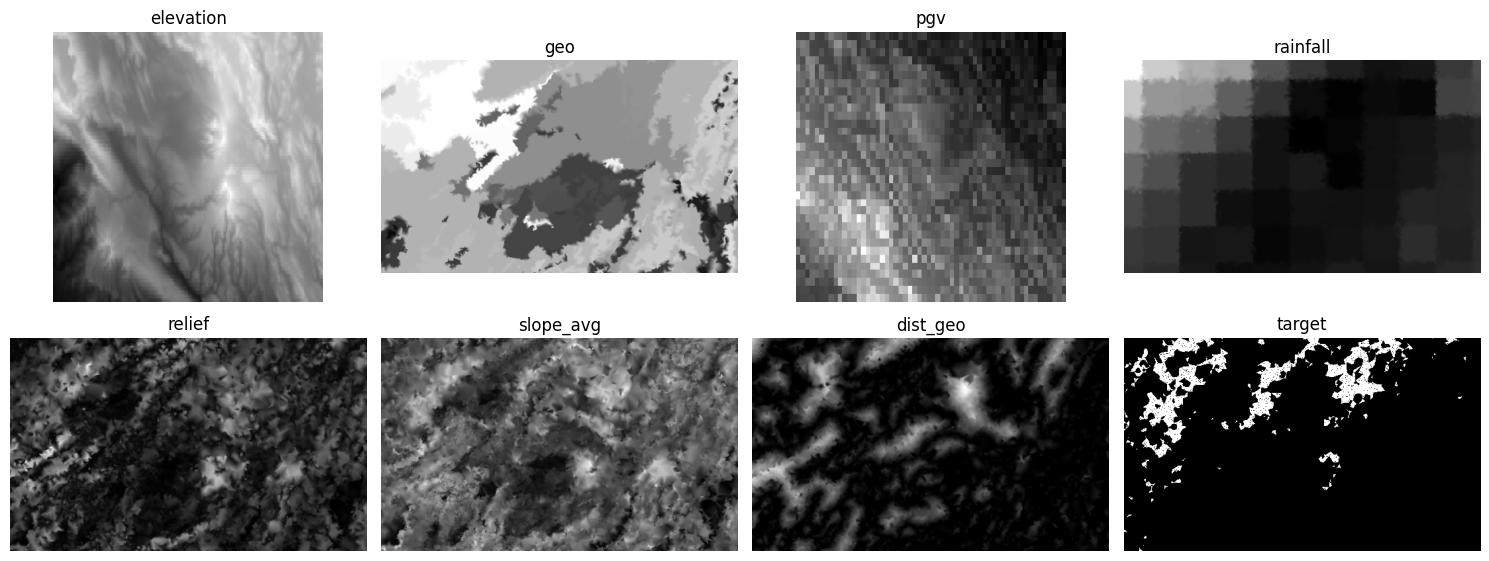

In [9]:
###visualizing original images### 
orgnl_imgs = [read_image(f) for f in data_imgs]
plot_images(orgnl_imgs, [f.split('.')[0] for f in data_imgs])
#plot_images(orgnl_imgs, [f"Feature {i+1}" for i in range(len(orgnl_imgs))])

In [10]:
###a function ot demean: center mean around 0 and entire range between 0 and 1###
def demean(image):
    image_mean = image.mean()
    image -= image_mean
    image_max = np.abs(image).max()
    if image_max != 0:
        image = image / image_max    
    image = np.maximum(image, 0)
    return image

###a function to convert data into binary format###  
def binarize(image):
    image[image > 0.5] = 1.
    image[image <= 0.5] = 0.
    return image





In [11]:
###applying demeaning to the features### 
rd_imgs_de=[]

for img in feature_imgs:
    rd_imgs=read_image(img)
    rd_imgs_d=demean(rd_imgs)
    rd_imgs_de.append(rd_imgs_d)

In [12]:
###processing the features (resize, into torch tensor, augmentation)###
prossd_imgs = [preprocess_image(imgs) for imgs in rd_imgs_de]
prossd_imgs_aug = [preprocess_image_augment(imgs) for imgs in rd_imgs_de]
prossd_imgs_augv = [preprocess_image_augmentv(imgs) for imgs in rd_imgs_de]

In [13]:
###stacking features to form a multichannel image###
stkd_features = torch.cat(prossd_imgs, dim=0)
stkd_features_aug = torch.cat(prossd_imgs_aug, dim=0)
stkd_features_augv = torch.cat(prossd_imgs_augv, dim=0)
print("Shape of stacked images tensor:", stkd_features.shape)
print("type of stacked images tensor:", stkd_features.dtype)
print("Shape of stacked images-H aug- tensor:", stkd_features_aug.shape)
print("type of stacked images-H aug- tensor:", stkd_features_aug.dtype)
print("Shape of stacked images-V aug- tensor:", stkd_features_augv.shape)
print("type of stacked images-V aug- tensor:", stkd_features_augv.dtype)

###binarizing and processing the targets (resize, into torch tensor, augmentation)###
rd_target = read_image(target_img)
rd_target_bi = binarize(rd_target)
prossd_target = preprocess_image(rd_target_bi )
prossd_target_aug = preprocess_image_augment(rd_target_bi )
prossd_target_augv = preprocess_image_augmentv(rd_target_bi )
print("Shape of target tensor:", prossd_target.shape)
print("type of target tensor:", prossd_target.dtype)
print("Shape of target tensor-H aug-:", prossd_target_aug.shape)
print("type of target tensor-H aug-:", prossd_target_aug.dtype)
print("Shape of target tensor-V aug-:", prossd_target_augv.shape)
print("type of target tensor-V aug-:", prossd_target_augv.dtype)

Shape of stacked images tensor: torch.Size([7, 200, 200])
type of stacked images tensor: torch.float32
Shape of stacked images-H aug- tensor: torch.Size([7, 200, 200])
type of stacked images-H aug- tensor: torch.float32
Shape of stacked images-V aug- tensor: torch.Size([7, 200, 200])
type of stacked images-V aug- tensor: torch.float32
Shape of target tensor: torch.Size([1, 200, 200])
type of target tensor: torch.float32
Shape of target tensor-H aug-: torch.Size([1, 200, 200])
type of target tensor-H aug-: torch.float32
Shape of target tensor-V aug-: torch.Size([1, 200, 200])
type of target tensor-V aug-: torch.float32


[0 1]


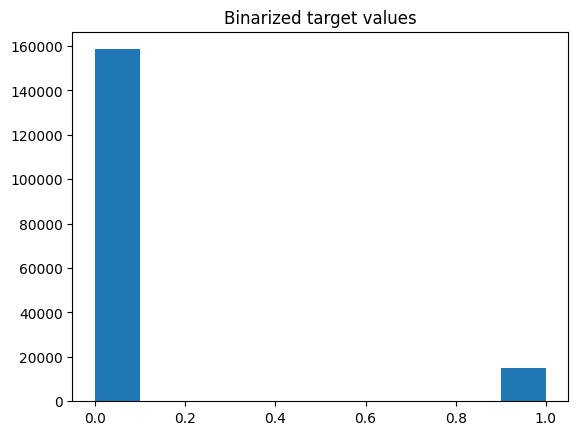

In [14]:
### showing values of the target after binarizing before converting them to tensors ###
plt.hist(rd_target_bi.ravel())
plt.title('Binarized target values')
print(np.unique(rd_target_bi))

tensor([0.0000e+00, 5.3768e-04, 6.1124e-04,  ..., 9.9936e-01, 9.9959e-01,
        1.0000e+00], device='cuda:0')


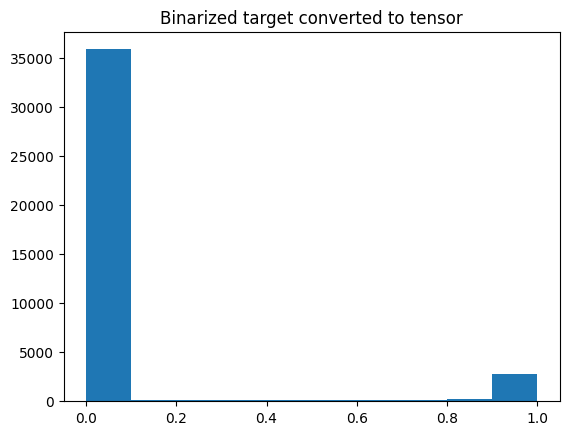

In [15]:
### showing values of the binarized target after processing and converting it to a tensor  ###
plt.hist(prossd_target.ravel().cpu())
plt.title('Binarized target converted to tensor')
print(torch.unique(prossd_target))

In [16]:
### a function to binarize the target tensor since they showed values between 0 and 1###
def binarize_tensor(tensor, threshold=0.5):
    binary_tensor = (tensor > threshold).float()  
    return binary_tensor


### Binarizing the targets(real, V-aug, and H-aug) ### 
prossd_target_bi = binarize_tensor(prossd_target)
prossd_target_bi_aug = binarize_tensor(prossd_target_aug)
prossd_target_bi_augv = binarize_tensor(prossd_target_augv)
print(torch.unique(prossd_target_bi))
print(torch.unique(prossd_target_aug))
print(torch.unique(prossd_target_augv))

tensor([0., 1.], device='cuda:0')
tensor([0.0000e+00, 5.3768e-04, 6.1124e-04,  ..., 9.9936e-01, 9.9959e-01,
        1.0000e+00], device='cuda:0')
tensor([0.0000e+00, 5.3768e-04, 6.1124e-04,  ..., 9.9936e-01, 9.9959e-01,
        1.0000e+00], device='cuda:0')


(array([36505.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  3495.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

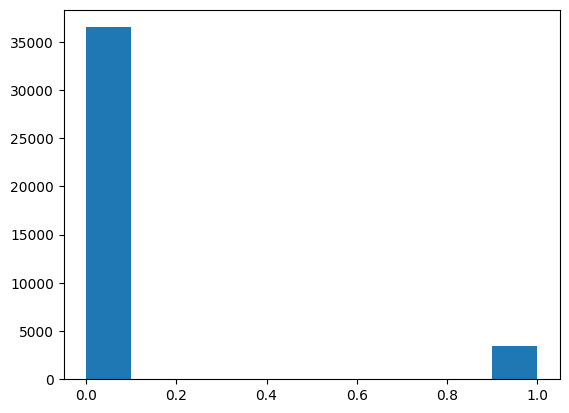

In [17]:
### showing values of the target tensor after binarizing ###
plt.hist(prossd_target_bi.ravel().cpu())

In [18]:
print(torch.min(prossd_target_bi))
print(torch.max(prossd_target_bi))
print(torch.min(stkd_features))
print(torch.max(stkd_features))

tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


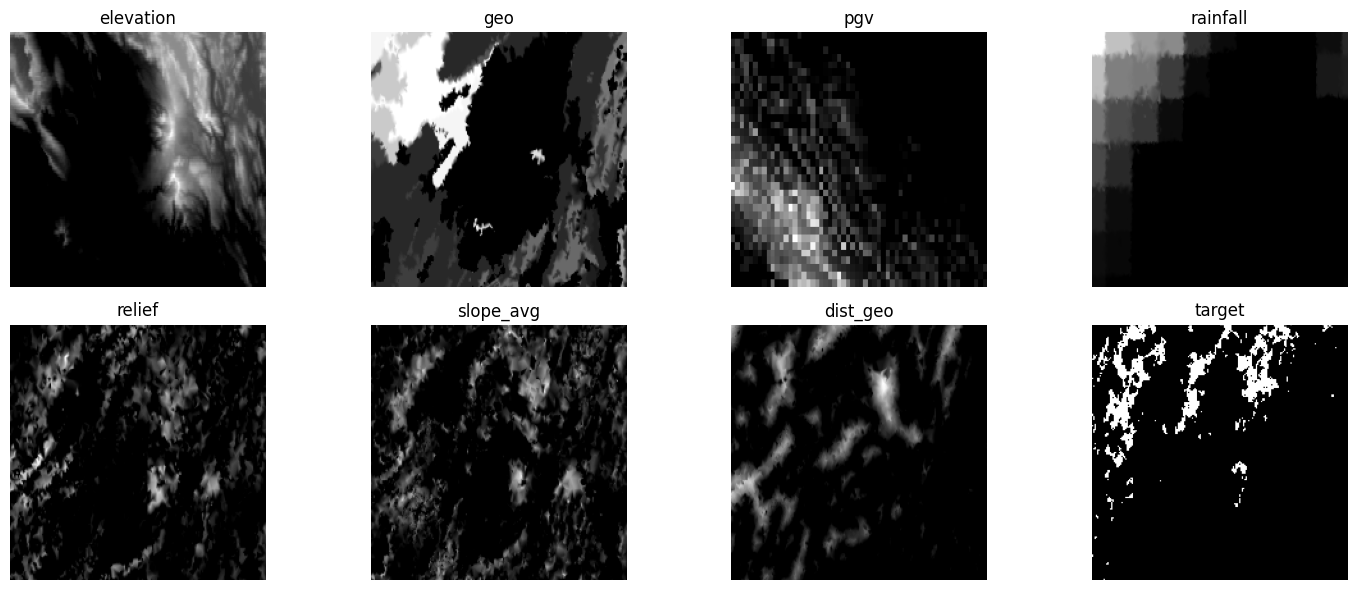

In [19]:
### visualizing images after processing ###
titles = [f.split('/')[-1].split('.')[0] for f in data_imgs]

processed_imgs_cpu=[]
for i in prossd_imgs:
    g=i.cpu()
    processed_imgs_cpu.append(g)
    
processed_imgs_cpu.append(prossd_target_bi.cpu())
plot_images(processed_imgs_cpu, titles)

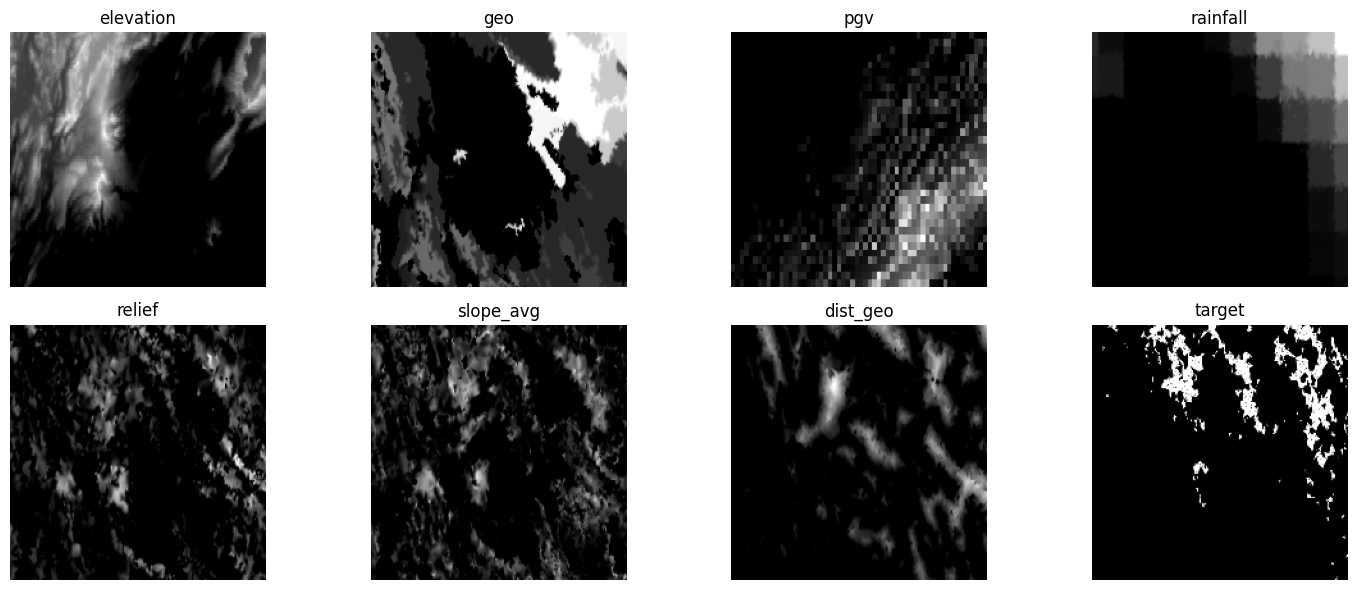

In [20]:
### Horizontally augmented ###
processedH_imgs_cpu=[]
for i in prossd_imgs_aug:
    g=i.cpu()
    processedH_imgs_cpu.append(g)

processedH_imgs_cpu.append(prossd_target_aug.cpu())    
plot_images(processedH_imgs_cpu, titles)

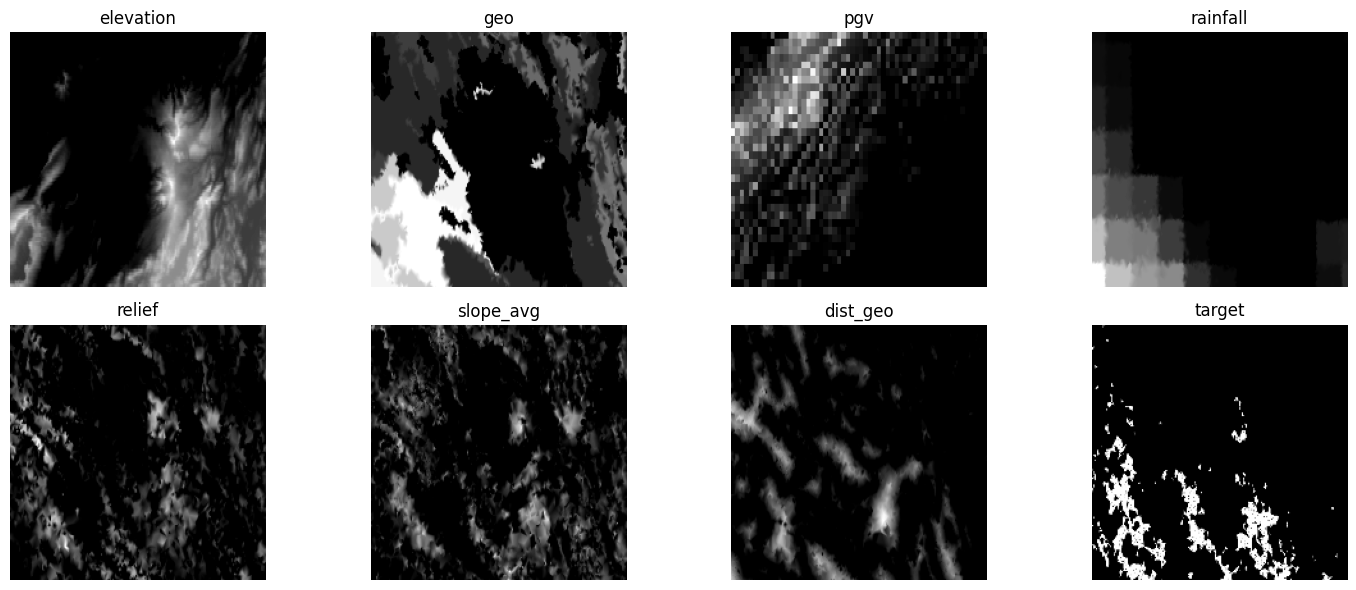

In [21]:
### vertically augmented ###
processedv_imgs_cpu=[]
for i in prossd_imgs_augv:
    g=i.cpu()
    processedv_imgs_cpu.append(g)

processedv_imgs_cpu.append(prossd_target_augv.cpu())    
plot_images(processedv_imgs_cpu, titles)

In [22]:
### patch the feature image and the target,and create the dataset ###
class LandslideDataset(Dataset):
    def __init__(self, features, target, patch_size=wandb.config["patch_size"]):
        self.features = features  # (channels, height, width)
        self.target = target      # (1, height, width)
        self.patch_size = patch_size
        self.patches_row = features.shape[1] // patch_size[0]
        self.patches_col = features.shape[2] // patch_size[1]
        self.total_patches = self.patches_row * self.patches_col

    def __len__(self):
        return self.total_patches

    def __getitem__(self, idx):
        # Calculate patch position
        row = (idx // self.patches_col) * self.patch_size[0]
        col = (idx % self.patches_col) * self.patch_size[1]
        # Extract the patch
        features_patch = self.features[:, row:row+self.patch_size[0], col:col+self.patch_size[1]]
        target_patch = self.target[:, row:row+self.patch_size[0], col:col+self.patch_size[1]]  
        return features_patch, target_patch

In [23]:
### create real, V-aug, and H-aug datasets 
dataset = LandslideDataset(stkd_features, prossd_target_bi)
dataset_aug = LandslideDataset(stkd_features_aug, prossd_target_bi_aug)
dataset_augv = LandslideDataset(stkd_features_augv, prossd_target_bi_augv)

In [24]:
### create a dataset that have all the three ###
final_dataset=ConcatDataset([dataset,dataset_aug,dataset_augv])

In [25]:
### divide dataset into training and validation ###
total_size = len(final_dataset)  # Total number of items in the dataset
train_size = int(0.9 * total_size)  # 90% of the dataset for training
valid_size = total_size - train_size  # 10% of the dataset for testing


traindata, validata = random_split(
    final_dataset, 
    [train_size, valid_size],
    generator=torch.Generator().manual_seed(42) )

In [26]:
print('dataset:', len(final_dataset))
print('train samples:', len(traindata))
print('Validation samples:', len(validata))

dataset: 192
train samples: 172
Validation samples: 20


In [27]:
sample_feature_patch, sample_target_patch = validata[0]  # Access patches in validation set  to check the size 
print("Single feature patch shape:", sample_feature_patch.shape)
print("Single target patch shape:", sample_target_patch.shape)

Single feature patch shape: torch.Size([7, 24, 24])
Single target patch shape: torch.Size([1, 24, 24])


In [28]:
print("Single feature patch shape:", sample_feature_patch.dtype)
print("Single target patch shape:", sample_target_patch.dtype)

Single feature patch shape: torch.float32
Single target patch shape: torch.float32


In [29]:
### dataset and data loader of the entire patched real data for model evaluation ###
special_dataset = LandslideDataset(stkd_features, prossd_target_bi)
special_loader = DataLoader(special_dataset, batch_size=wandb.config["batch_size"], shuffle=True)

In [30]:
### for creating dataset with the entire image (no patching) ###
class LandslideDataset1(Dataset):
    def __init__(self, features, target):
        self.features = features  
        self.target = target      
    def __len__(self):
        
        return len(self.features)

    def __getitem__(self, idx):
    
        features_sample = self.features[idx]
        target_sample = self.target[idx]
        return features_sample, target_sample

In [31]:
### dataset and loader of the real data with no patching ###
whole_data=LandslideDataset1(stkd_features.unsqueeze(0), prossd_target_bi.unsqueeze(0))
Whole_loader = DataLoader(whole_data, batch_size=1, shuffle=False)


inputs, targets = next(iter(Whole_loader))
print(inputs.shape)
print(targets.shape)

torch.Size([1, 7, 200, 200])
torch.Size([1, 1, 200, 200])


In [32]:
### a function to plot some of the dataset samples(patches) ###
def plot_dataset_samples(dataset, num_samples=6):
    num_columns = 3
    num_rows = (num_samples + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns * 2, figsize=(num_columns * 4, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_samples):
        
        feature_patch, target_patch = dataset[i]  
        
        # add to cpu for plotting
        if feature_patch.is_cuda:
            feature_patch = feature_patch.cpu()
        if target_patch.is_cuda:
            target_patch = target_patch.cpu()
        
        ax_feat = axes[i * 2]
        ax_targ = axes[i * 2 + 1]

        # change index for different channels
        ax_feat.imshow(feature_patch[0], cmap='gray')  
        ax_feat.set_title(f'Feature Patch {i}')
        ax_feat.axis('off')
        
        
        ax_targ.imshow(target_patch[0], cmap='gray')
        ax_targ.set_title(f'Target Patch {i}')
        ax_targ.axis('off')

    plt.tight_layout()
    plt.show()



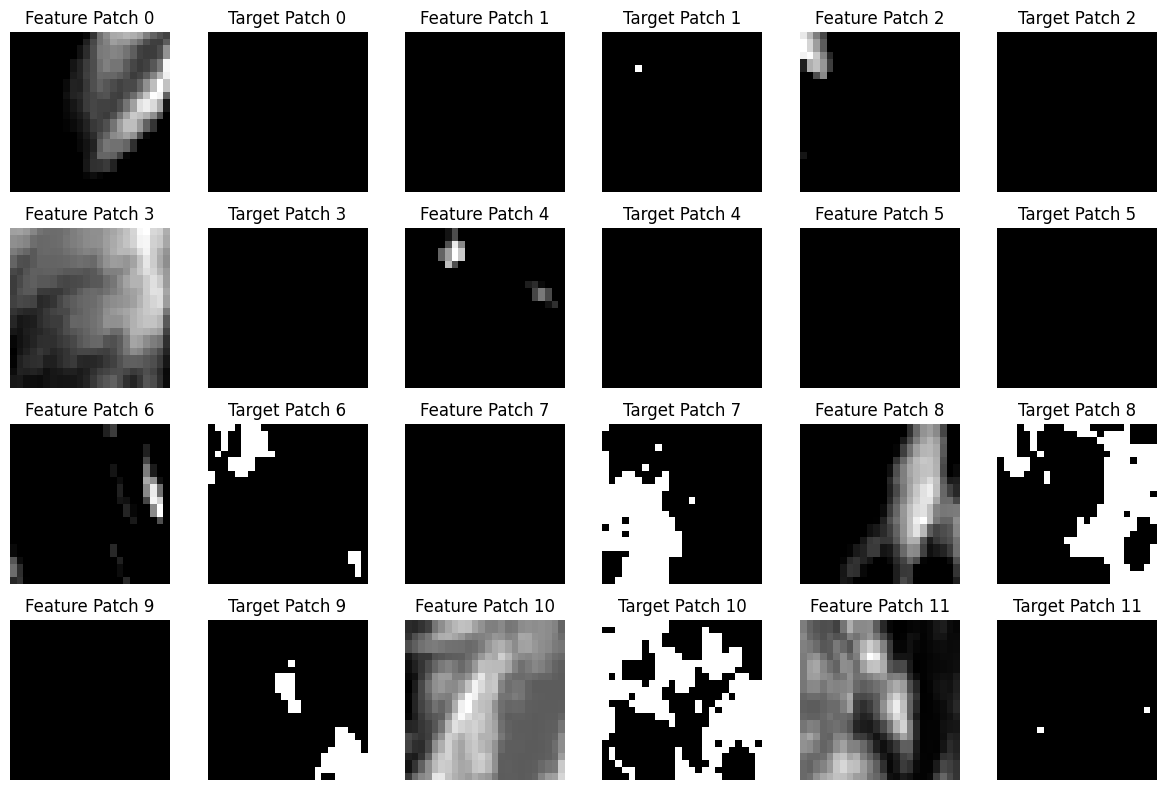

In [33]:
### Plot a sample of the patches from the dataset ###
plot_dataset_samples(traindata, num_samples=12)

In [34]:
### creat train and validation loaders ###
train_loader = DataLoader(traindata, batch_size=wandb.config["batch_size"], shuffle=True)
val_loader = DataLoader(validata, batch_size=wandb.config["batch_size"], shuffle=False)

In [35]:
for inputs, targetss in train_loader:
    print (inputs.shape, targetss.shape)
    break

torch.Size([32, 7, 24, 24]) torch.Size([32, 1, 24, 24])


## 2.Training 

-The deep learning model used is a U-Net and R2-UNet(attached in a separate file). Also, used Adam optimizer and BCE loss function. 

-Dropout regularization was used in the model.

-As evaluation metrics, used accuracy, F1 score, and RMSE.


In [94]:
### loading the UNet ###
set_seed(42)
network = UNet(7, 1, hidden_channels=wandb.config["hidden_channels"]).to(device)
# network = network.apply(weights_init) 
print(network)

UNet(
  (upfeature): FeatureMapBlock(
    (conv): Conv2d(7, 44, kernel_size=(1, 1), stride=(1, 1))
  )
  (contracts): Sequential(
    (0): ContractingBlock(
      (conv1): Conv2d(44, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(88, 88, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(88, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    )
    (1): ContractingBlock(
      (conv1): Conv2d(88, 176, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(176, 176, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm): BatchNorm2d(176, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)


In [101]:
### defining the loss and optimizer ###
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=wandb.config["lr"], weight_decay=wandb.config["weight_decay"])

In [102]:
### a function to calculate accuracy and F1 score metrics ###
def compute_metrics(predictions, targets):
    # Flatten lists
    predictions = torch.cat([torch.tensor(batch) for batch in predictions])
    targets = torch.cat([torch.tensor(batch) for batch in targets])
    
    # Binarize predictions
    predictions = (predictions > 0.5).float().to(device)
    
    # Calculate accuracy
    correct = (predictions == targets).float().sum()
    accuracy = correct / targets.numel()
    
    # Calculate precision, recall, and F1
    tp = (predictions * targets).sum().to(torch.float32)
    tn = ((1 - predictions) * (1 - targets)).sum().to(torch.float32)
    fp = (predictions * (1 - targets)).sum().to(torch.float32)
    fn = ((1 - predictions) * targets).sum().to(torch.float32)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy.item(), f1.item()



/tmp/ipykernel_3192/909094118.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.cat([torch.tensor(batch) for batch in targets])
/tmp/ipykernel_3192/909094118.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.cat([torch.tensor(batch) for batch in predictions])


Epoch 10/150, Train Loss: 0.21731474995613098, Valid Loss: 0.20016880333423615, train accuracy: 0.8644076585769653, valid accuracy: 0.8485243320465088, train F1: 0.21675704419612885, valid F1: 0.1974797546863556


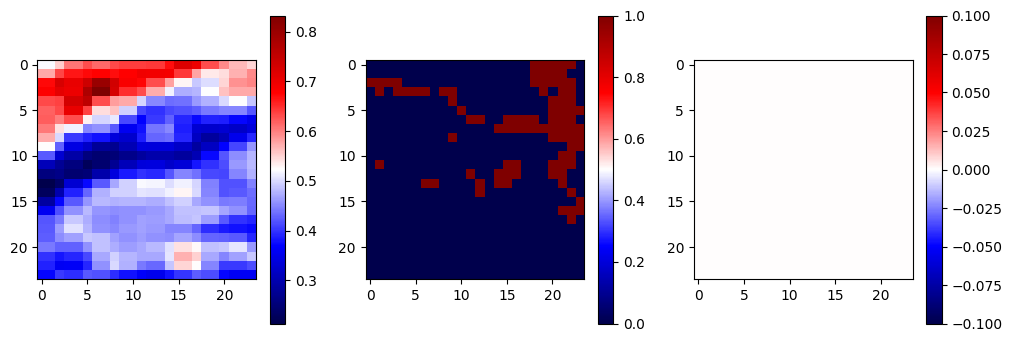

Epoch 20/150, Train Loss: 0.2044642815987269, Valid Loss: 0.1874048113822937, train accuracy: 0.8896180987358093, valid accuracy: 0.8858984708786011, train F1: 0.30029335618019104, valid F1: 0.2492503821849823


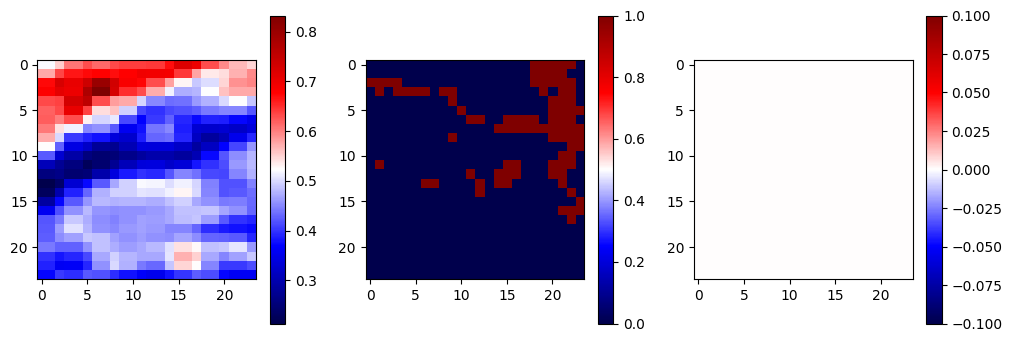

Epoch 30/150, Train Loss: 0.20056323955456415, Valid Loss: 0.19628459215164185, train accuracy: 0.8997176885604858, valid accuracy: 0.8977488279342651, train F1: 0.33521950244903564, valid F1: 0.22883205115795135


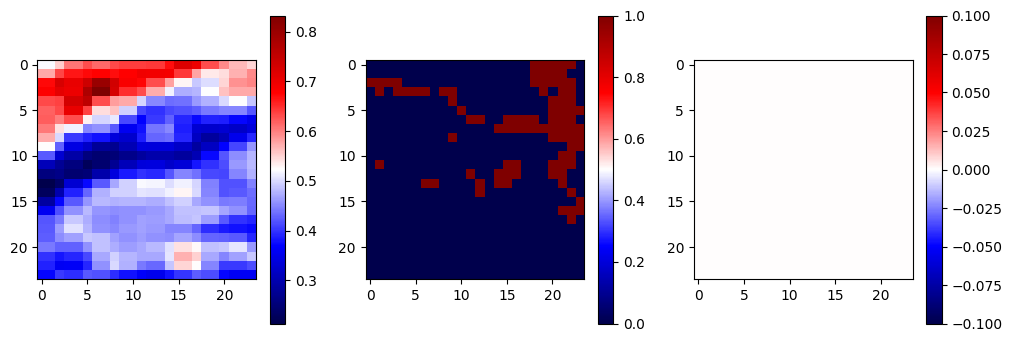

Epoch 40/150, Train Loss: 0.18682201951742172, Valid Loss: 0.18377138674259186, train accuracy: 0.9055308103561401, valid accuracy: 0.9043077230453491, train F1: 0.3600993752479553, valid F1: 0.21122302114963531


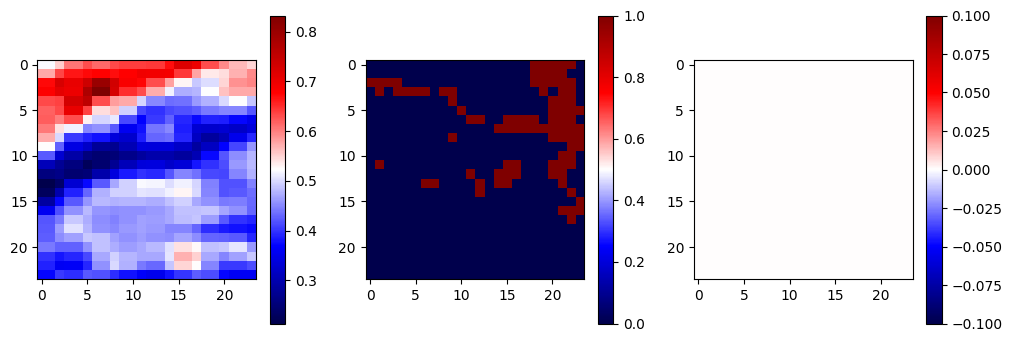

Epoch 50/150, Train Loss: 0.20044388622045517, Valid Loss: 0.17665643990039825, train accuracy: 0.909145712852478, valid accuracy: 0.9080642461776733, train F1: 0.3777672052383423, valid F1: 0.19858649373054504


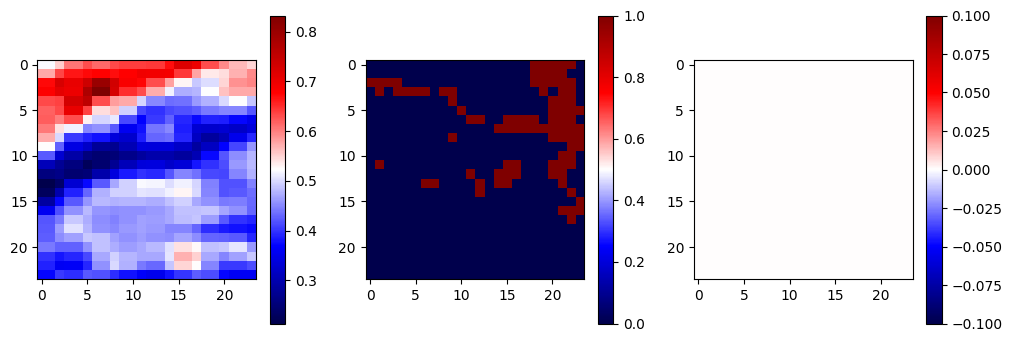

Epoch 60/150, Train Loss: 0.1910863940914472, Valid Loss: 0.1792646050453186, train accuracy: 0.9117653369903564, valid accuracy: 0.9109780192375183, train F1: 0.39153924584388733, valid F1: 0.19805026054382324


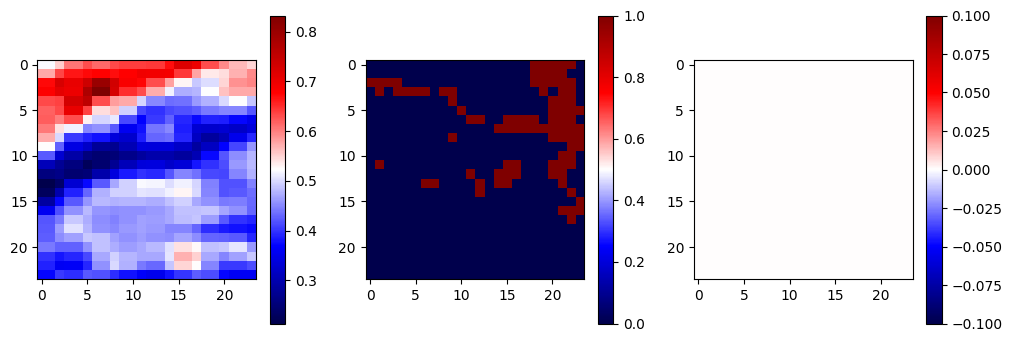

Epoch 70/150, Train Loss: 0.20065717150767645, Valid Loss: 0.1802590787410736, train accuracy: 0.9137243032455444, valid accuracy: 0.9139087200164795, train F1: 0.4040249288082123, valid F1: 0.21221888065338135


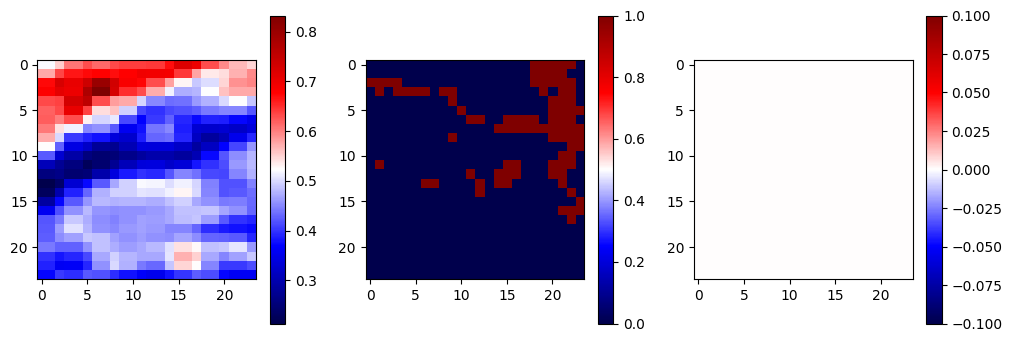

Epoch 80/150, Train Loss: 0.17747529844443002, Valid Loss: 0.1749047487974167, train accuracy: 0.9153671860694885, valid accuracy: 0.9160059094429016, train F1: 0.41613462567329407, valid F1: 0.22307421267032623


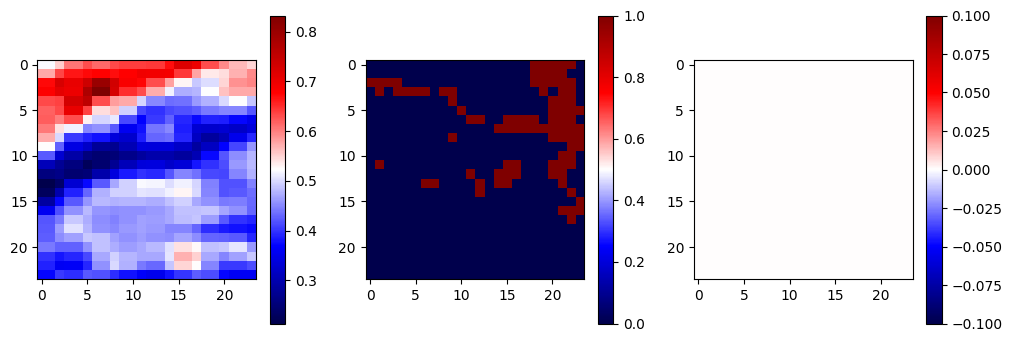

Epoch 90/150, Train Loss: 0.1670292690396309, Valid Loss: 0.16581347584724426, train accuracy: 0.9166948199272156, valid accuracy: 0.9180073142051697, train F1: 0.4276750981807709, valid F1: 0.24022234976291656


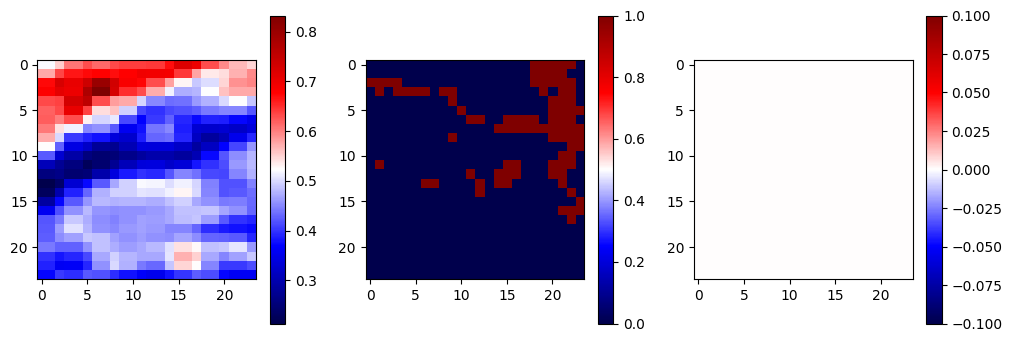

Epoch 100/150, Train Loss: 0.15552919482191405, Valid Loss: 0.16145257651805878, train accuracy: 0.9179505109786987, valid accuracy: 0.9197829961776733, train F1: 0.440093994140625, valid F1: 0.25971320271492004


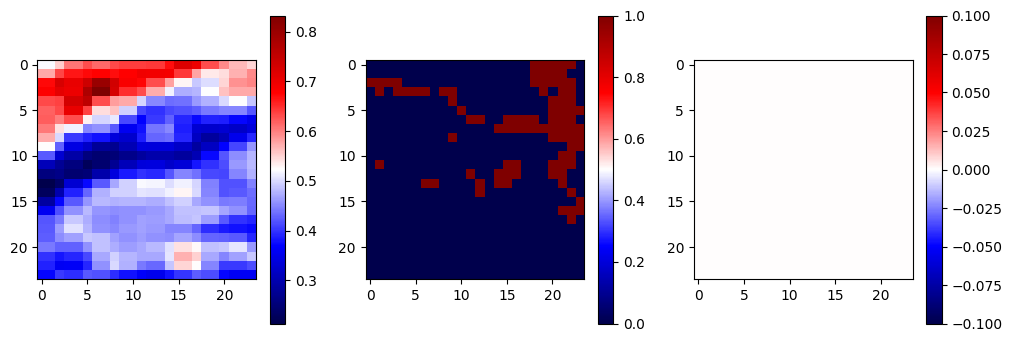

Epoch 110/150, Train Loss: 0.17946253716945648, Valid Loss: 0.16475264728069305, train accuracy: 0.9191627502441406, valid accuracy: 0.9214410185813904, train F1: 0.4533270597457886, valid F1: 0.2842557728290558


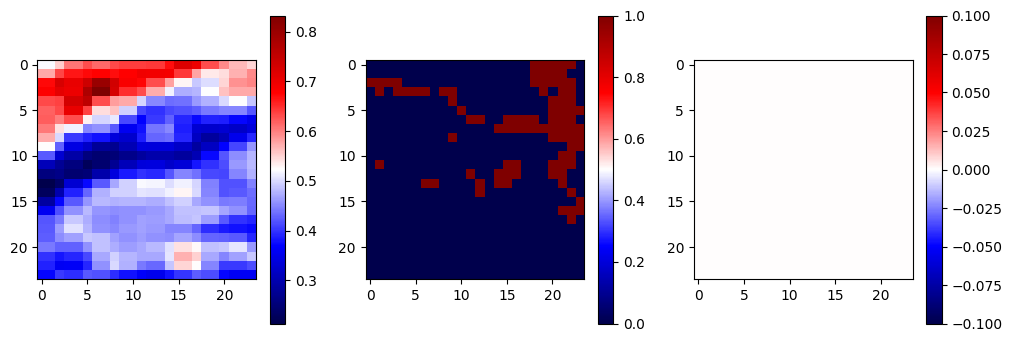

Epoch 120/150, Train Loss: 0.14551818619171777, Valid Loss: 0.16615024209022522, train accuracy: 0.9200372695922852, valid accuracy: 0.922624409198761, train F1: 0.46221739053726196, valid F1: 0.294460654258728


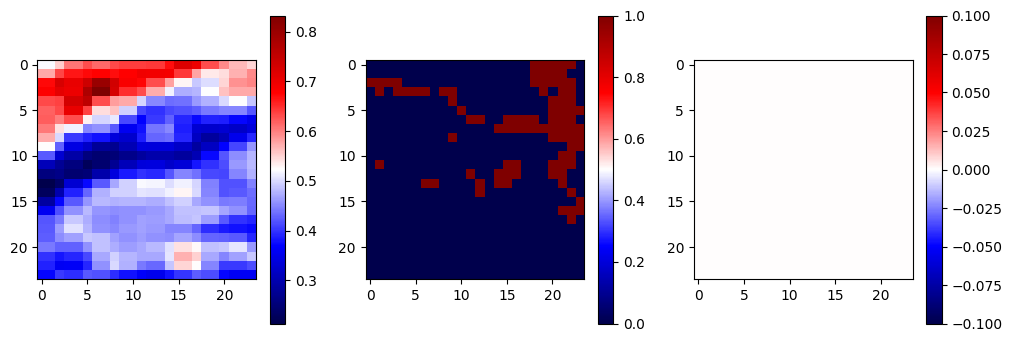

Epoch 130/150, Train Loss: 0.15261745701233545, Valid Loss: 0.16729986667633057, train accuracy: 0.9211167097091675, valid accuracy: 0.9239269495010376, train F1: 0.47335508465766907, valid F1: 0.31232985854148865


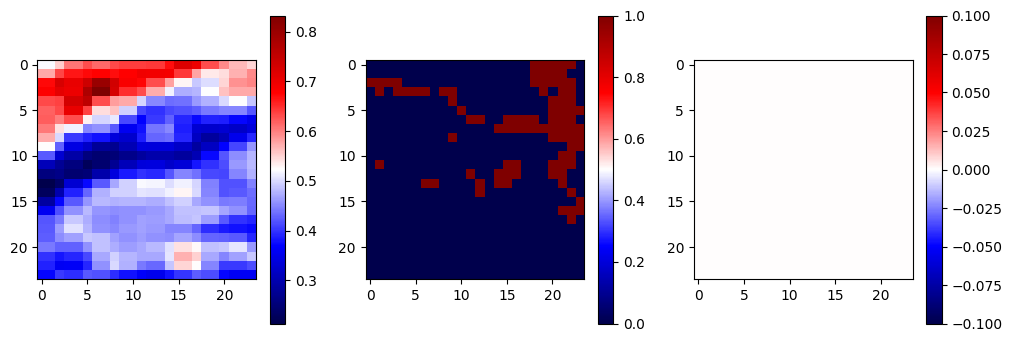

Epoch 140/150, Train Loss: 0.14046275988221169, Valid Loss: 0.14793561398983002, train accuracy: 0.9222378730773926, valid accuracy: 0.9251605272293091, train F1: 0.48413175344467163, valid F1: 0.33005303144454956


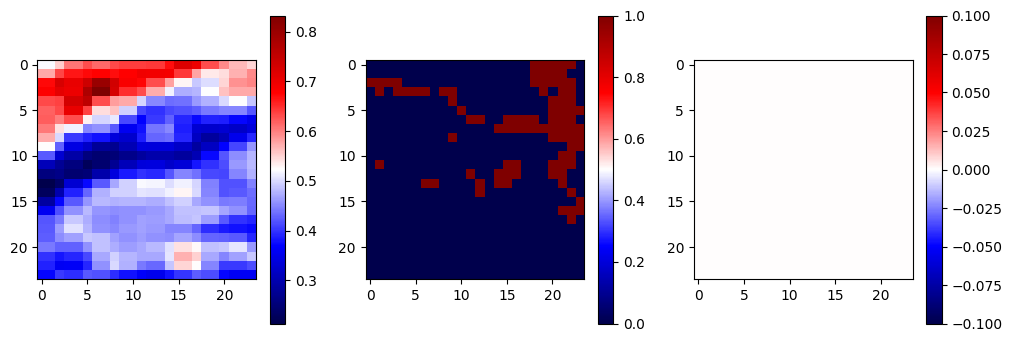

Epoch 150/150, Train Loss: 0.14247758562366167, Valid Loss: 0.15403127670288086, train accuracy: 0.9233854413032532, valid accuracy: 0.9261556267738342, train F1: 0.49505430459976196, valid F1: 0.34688833355903625


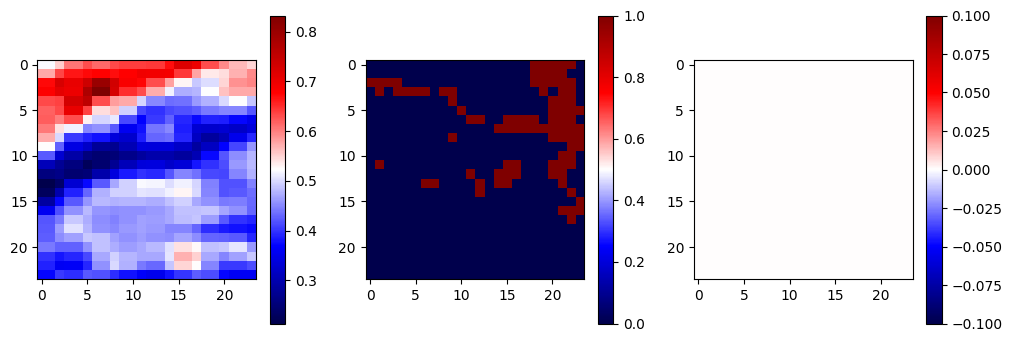

In [104]:
### training loop ###
epochs =150


train_loss_history = []
valid_loss_history = []

train_predictions = []
train_targets = []
valid_predictions = []
valid_targets = []

train_accuracies=[]
train_f1s=[]
valid_accuracies=[]
valid_f1s=[]


network.train() #train
for epoch in range(epochs):
    train_loss = 0.0
    for inputs, targets in train_loader:
        # print(inputs.shape, targets.shape)
        # inputs=inputs_ #.to(device)
        # targets=targets_ #.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        ypred = (outputs.detach().cpu().numpy() > 0.5).astype(float)
        # outputs_sigmoid = torch.sigmoid(outputs)
        loss = criterion(outputs, targets)
        # print(outputs.shape)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        train_predictions.append(ypred)
        train_targets.append(targets)
    
    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    # Calculate training metrics
    train_accuracy, train_f1 = compute_metrics(train_predictions, train_targets)
    train_accuracies.append(train_accuracy)
    train_f1s.append(train_f1)
    

    network.eval() #validation
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs=inputs #.to(device)
            targets=targets #.to(device)
            outputs = network(inputs)
            ypred = (outputs.detach().cpu().numpy() > 0.5).astype(float)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()
            
            
            valid_predictions.append(outputs)
            valid_targets.append(targets)
            
        valid_loss /= len(val_loader)
        valid_loss_history.append(valid_loss)
    # Calculate validation metrics
        valid_accuracy, valid_f1 = compute_metrics(valid_predictions, valid_targets)
        valid_accuracies.append(valid_accuracy)
        valid_f1s.append(valid_f1)
    
    
    wandb.log({'Epoch': epoch, 'Train Loss': train_loss, 'Validation Loss': valid_loss, 'train accuracy':train_accuracy, 'valid accuracy': valid_accuracy, 'train F1': train_f1, 'valid F1': valid_f1 })
    
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, train accuracy: {train_accuracy}, valid accuracy: {valid_accuracy}, train F1: {train_f1}, valid F1: {valid_f1}")

        
        fig, axs = plt.subplots(1,3, figsize=(12, 4))
        im0=axs[0].imshow(inputs[0,0].cpu().T,cmap='seismic')
        fig.colorbar(im0, ax=axs[0],orientation='vertical')
        im1=axs[1].imshow(targets[0,0].cpu().T,cmap='seismic')
        fig.colorbar(im1, ax=axs[1], orientation='vertical')
        im2=axs[2].imshow(ypred[0,0],cmap='seismic')
        fig.colorbar(im2, ax=axs[2], orientation='vertical')
        plt.show()
        
        wandb.log({"examples": [wandb.Image(fig, caption="Input, Target, Prediction")]})
        plt.close(fig)



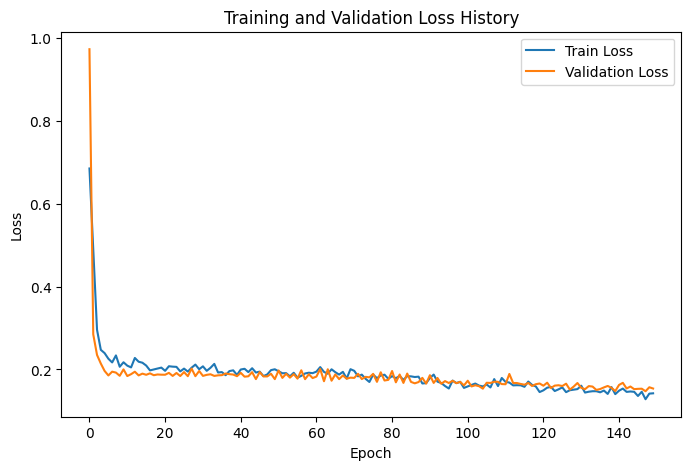

In [105]:
### plot train and validation history ###
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plot_path = 'loss_history.png'  
plt.savefig(plot_path)
plt.show()

wandb.log({"Loss History Plot": wandb.Image(plot_path)})
plt.close()




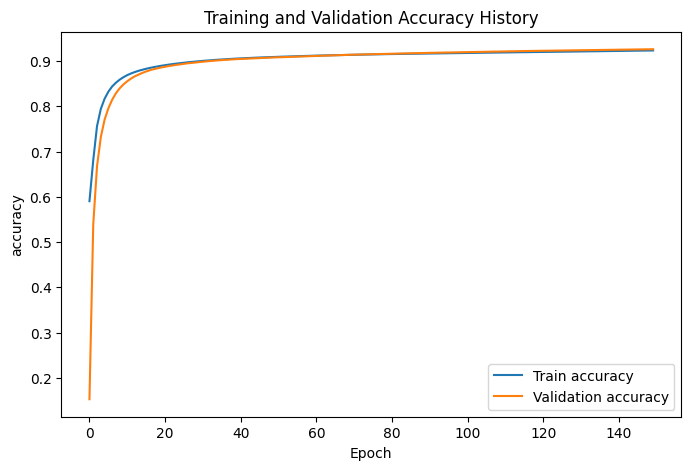

In [106]:
### plot train and validation accuracy history ###
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.title('Training and Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

plot_path2 = 'accuracy_history.png'  
plt.savefig(plot_path2)
plt.show()

wandb.log({"Accuracy History Plot": wandb.Image(plot_path2)})
plt.close()




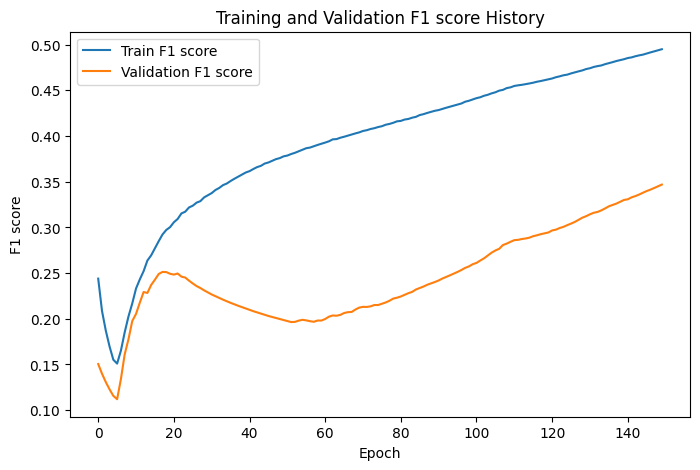

In [108]:
### plot train and validation F1 score history ###
plt.figure(figsize=(8, 5))
plt.plot(train_f1s, label='Train F1 score')
plt.plot(valid_f1s, label='Validation F1 score')
plt.title('Training and Validation F1 score History')
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.legend()

plot_path3 = 'F1_history.png'  
plt.savefig(plot_path3)
plt.show()

wandb.log({"F1 scoore History Plot": wandb.Image(plot_path3)})
plt.close()

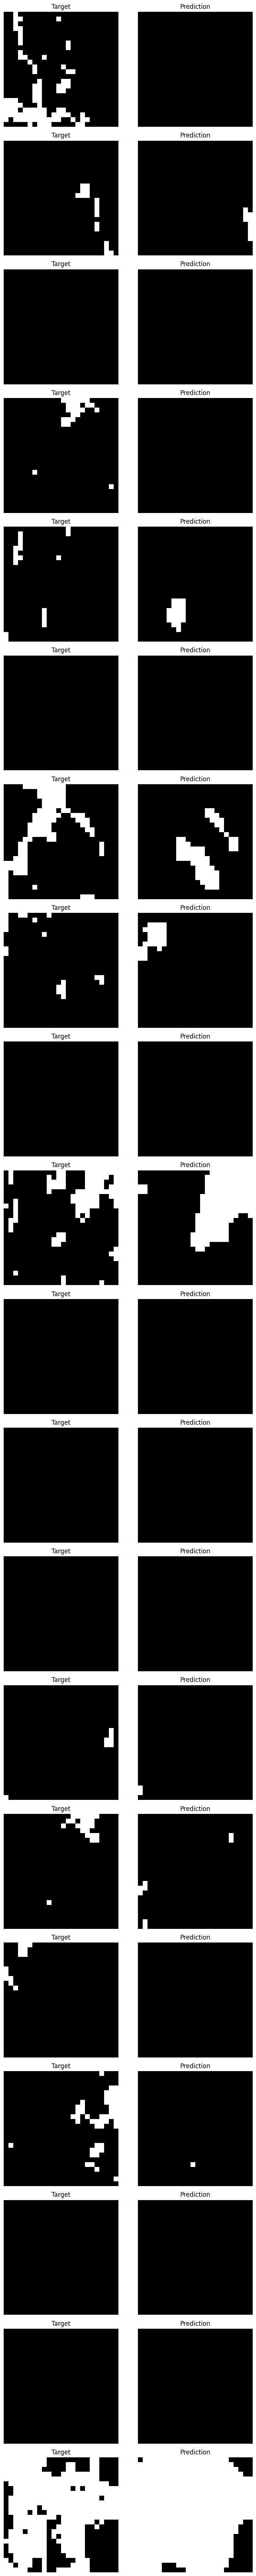

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train Loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁
Validation Loss,█▄▃▃▃▃▃▄▃▃▃▃▃▂▂▂▄▃▂▃▃▂▂▂▂▂▁▁▂▃▂▁▂▁▂▁▁▂▁▁
train F1,▂▁▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train accuracy,▁▄▆▇▇▇▇▇▇▇▇█████████████████████████████
valid F1,▂▁▂▄▅▅▅▄▄▄▄▄▄▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
valid accuracy,▁▄▆▇▇▇▇▇████████████████████████████████
Epoch,149
Train Loss,0.14248
Validation Loss,0.15403
train F1,0.49505


In [109]:
### evaluating the trained model on validation set or the special set defined above ###
network.eval()


predictions = []
targets_collected = [] 

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs  
        targets = targets  

        outputs = network(inputs) 
        ypred = (outputs > 0.5).float()  # Convert probabilities to binary output
        
        
        predictions.append(ypred.cpu().numpy())
        targets_collected.append(targets.cpu().numpy())

# plot results from the first batch
fig, axs = plt.subplots(nrows=len(predictions[0]), ncols=2, figsize=(8, 70))

for i in range(len(predictions[0])):
    ax = axs[i, 0]
    ax.imshow(targets_collected[0][i][0], cmap='gray')  
    ax.title.set_text('Target')
    ax.axis('off')
    
    ax = axs[i, 1]
    ax.imshow(predictions[0][i][0], cmap='gray') 
    ax.title.set_text('Prediction')
    ax.axis('off')

plt.tight_layout()
plt.show()
wandb.log({"targets vs predictions": [wandb.Image(fig, caption="Target, Prediction")]})
plt.close(fig)
wandb.finish()







In [110]:
### saving the trained model on the optimal parameters ###
torch.save(network.state_dict(), 'optimal.pth')

In [111]:
pretrained_dict=torch.load('optimal.pth')

In [112]:
### loading the optimal model ###
set_seed(42)
network = UNet(7, 1, hidden_channels=44).to(device)
network_dict = network.state_dict()
pretrained_dict={k: v for k, v in pretrained_dict.items() if k in network_dict}
network_dict.update(pretrained_dict)
network.load_state_dict(network_dict)

# print(network)

<All keys matched successfully>

In [113]:
inputs, targets = next(iter(Whole_loader))
print(inputs.shape)
print(targets.shape)

torch.Size([1, 7, 200, 200])
torch.Size([1, 1, 200, 200])


1


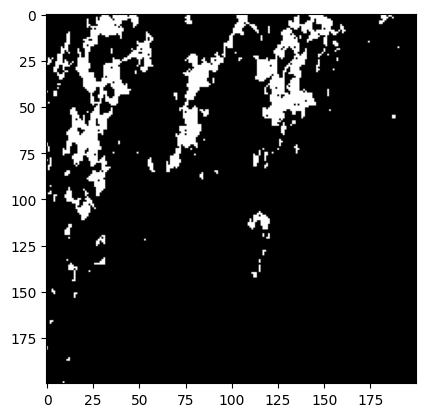

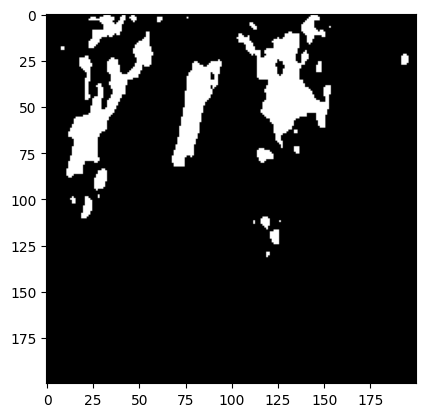

In [114]:
### evaluatng the optimal model on the entire non-patched real dataset ###
network.eval()

predictions = []
targets_collected = [] 

with torch.no_grad():
    for inputs, targets in Whole_loader:
        inputs = inputs  
        targets = targets  

        outputs = network(inputs)  
        ypred = (outputs > 0.5).float()  
        
       
        predictions.append(ypred.cpu().numpy())
        targets_collected.append(targets.cpu().numpy())
        

print(len(targets_collected ))
plt.imshow(targets_collected[0][0][0], cmap='gray')
# plt.imshow(predictions[0][0][0], cmap='gray')
plt.show()

plt.imshow(predictions[0][0][0], cmap='gray')
plt.show()




In [115]:
### calculating RMSE for the evaluation on the validation dataset ###

squared_diff = (torch.tensor(valid_targets[0]) - torch.tensor(valid_predictions[0])) ** 2 #squared differences
mse = torch.mean(squared_diff)
rmse = torch.sqrt(mse)

print("RMSE:", rmse.item())

RMSE: 0.612732470035553


/tmp/ipykernel_3192/1532608703.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  squared_diff = (torch.tensor(valid_targets[0]) - torch.tensor(valid_predictions[0])) ** 2


In [116]:
### calculating RMSE for the evaluation on the entire non-patched real dataset ###

squared_diff = (torch.tensor(targets_collected[0]) - torch.tensor(predictions[0])) ** 2 #squared differences
mse = torch.mean(squared_diff)
rmse = torch.sqrt(mse)

print("RMSE:", rmse.item())

RMSE: 0.2533278465270996
